# Tutorial
Put together by Kerem Okyay\
Sources: 
https://ccrma.stanford.edu/~njb/teaching/sstutorial/part2.pdf\
https://musicinformationretrieval.com



**decompose a matrix as a product of two or more matrices** 

                                    V = HW
- A is the data, audio spectrogram.(FxT)
- W is the basis vectors or dictionary. A single column is referred to as a basis vector. (FxK)
- H is the weights or the activation matrix. A row of H represents the gain of the corresponding basis vector. (KxT)


Columns of V as weighted sum of basis vectors.

In [21]:
%matplotlib inline
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import numpy as np
import scipy
import soundfile as sf

In [22]:
x, fs = librosa.load("../data/grandpiano.wav",duration=6)
ipd.Audio(x,rate=fs)

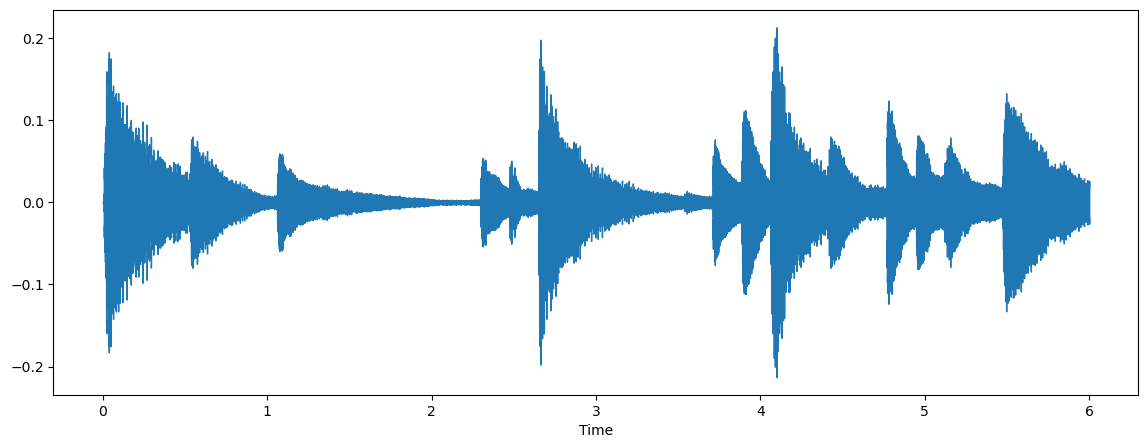

In [23]:
plt.figure(figsize=(14,5))
librosa.display.waveshow(x,sr=fs)

In [24]:
print(x.shape)
print(fs)

(132300,)
22050


### Short-Time Fourier Transform (STFT)
inputs time domain signal x\
outputs Magnitude |X| and phase <X matrices

The **short-time Fourier transform (STFT)** ([Wikipedia](https://en.wikipedia.org/wiki/Short-time_Fourier_transform); FMP, p. 53) is obtained by computing the Fourier transform for successive frames in a signal. 

$$ X(m, \omega) = \sum_n x(n) w(n-m) e^{-j \omega n} $$

As we increase $m$, we slide the window function $w$ to the right. For the resulting frame, $x(n) w(n-m)$, we compute the Fourier transform. Therefore, the STFT $X$ is a function of both time, $m$, and frequency, $\omega$.

In [25]:
X = librosa.stft(x)
# defaults: 
# n_fft(length of windowed signal after padding with zeros):2048
# hop_length(number of audio samples between adjacent STFT colums): win_length // 4
# win_length(each frame of audio is windowed by window of length win_length
# and them padded with zeros to match n_fft): n_fft = 2048
# window: scipy.signal.windows.hann

### Spectrogram
In music processing, we often only care about the spectral magnitude and not the phase content.

The **spectrogram** ([Wikipedia](https://en.wikipedia.org/wiki/Spectrogram); FMP, p. 29, 55) shows the the intensity of frequencies over time. A spectrogram is simply the squared magnitude of the STFT:

$$ S(m, \omega) = \left| X(m, \omega) \right|^2 $$

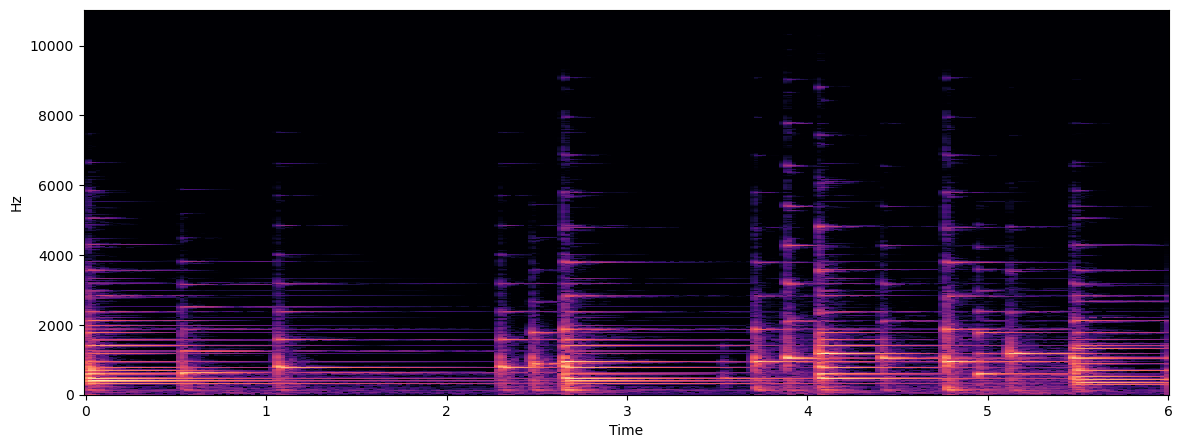

In [26]:
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14,5))
librosa.display.specshow(Xdb, sr=fs, x_axis='time', y_axis='hz')

 ### NMF
 inputs |X|, outputs W and H

[Nonnegative matrix factorization](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization) (NMF) is an algorithm that factorizes a nonnegative matrix, $X$, into a product of two nonnegative matrices, $W$ and $H$. It is an unsupervised iterative algorithm that minimizes a distance between $X$ and the product $WH$:

$$ \min_{W, H} d(X, WH) $$

If $X$ has dimensions $M$ by $N$, then $W$ will have dimensions $M$ by $R$, and $H$ will have dimensions $R$ by $N$, where inner dimension $R$ is the *rank* or *number of components* of the decomposition.

When applied to a musical signal, we find that NMF can decompose the signal into separate note events. Therefore, NMF is quite useful and popular for tasks such as transcription and source separation.

The input, $X$, is often a magnitude spectrogram. In such a case, we find that the columns of $W$ represent spectra of note events, and the rows of $H$ represent temporal envelopes of the same note events.

In [27]:
X_mag, X_phase = librosa.magphase(X)
n_components = 10 # change this to better understand what happens
W, H = librosa.decompose.decompose(X_mag,n_components=n_components, sort=True)

/Users/keremokyay/miniforge3/envs/spai/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


## Notice how similar the following plot to a piano roll represantation.
## These are the weights plotted against time.

However i do not understand fully what is the unit of the y axis


(10, 259)

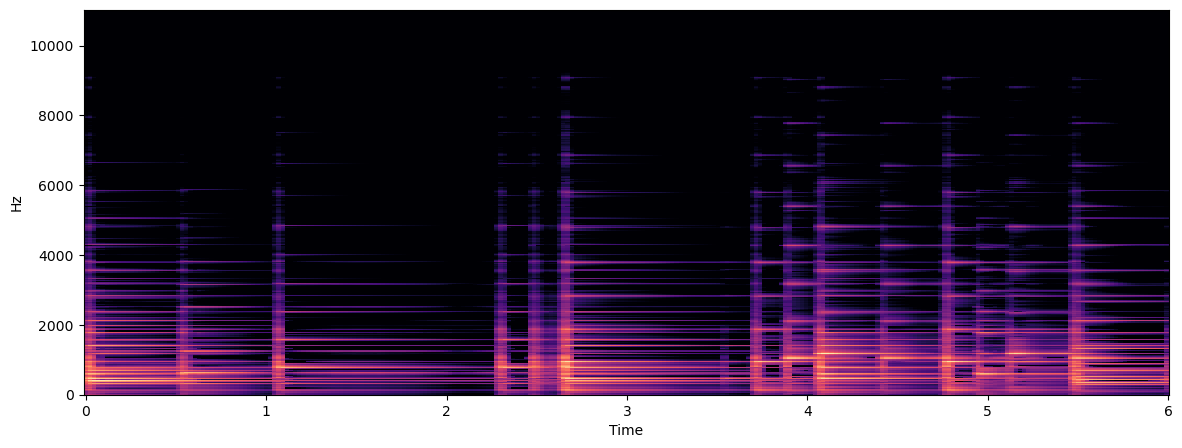

In [28]:
plt.figure(figsize=(14,5))
librosa.display.specshow(librosa.amplitude_to_db(np.dot(W,H)), sr=fs, x_axis='time', y_axis='hz')
# hz is the midi pitch 22 45 45 8 62 62
H.shape

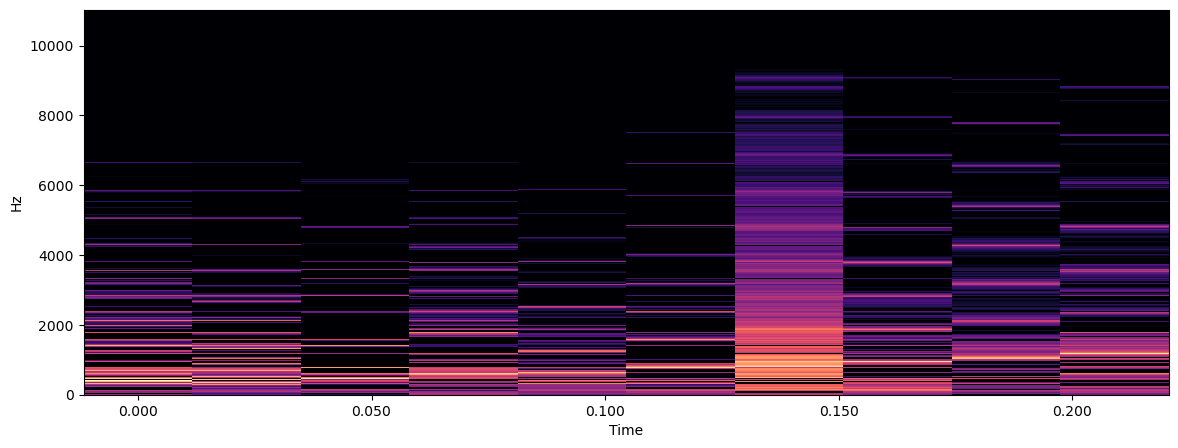

In [29]:
# these are the basis vectors plotted against time 
Wdb = librosa.amplitude_to_db(W)
plt.figure(figsize=(14,5))
librosa.display.specshow(Wdb, sr=fs, x_axis='time', y_axis='hz')

In [30]:
print(X.shape)
print(W.shape)
print(H.shape)

(1025, 259)
(1025, 10)
(10, 259)


Let's display the spectral profiles(basis vectors), $\{w_1, ..., w_R\}$:


387.219512195122
441.0
462.5121951219512
591.5853658536586
623.8536585365854
785.1951219512196
806.7073170731708
935.780487804878
1043.341463414634
1172.4146341463415


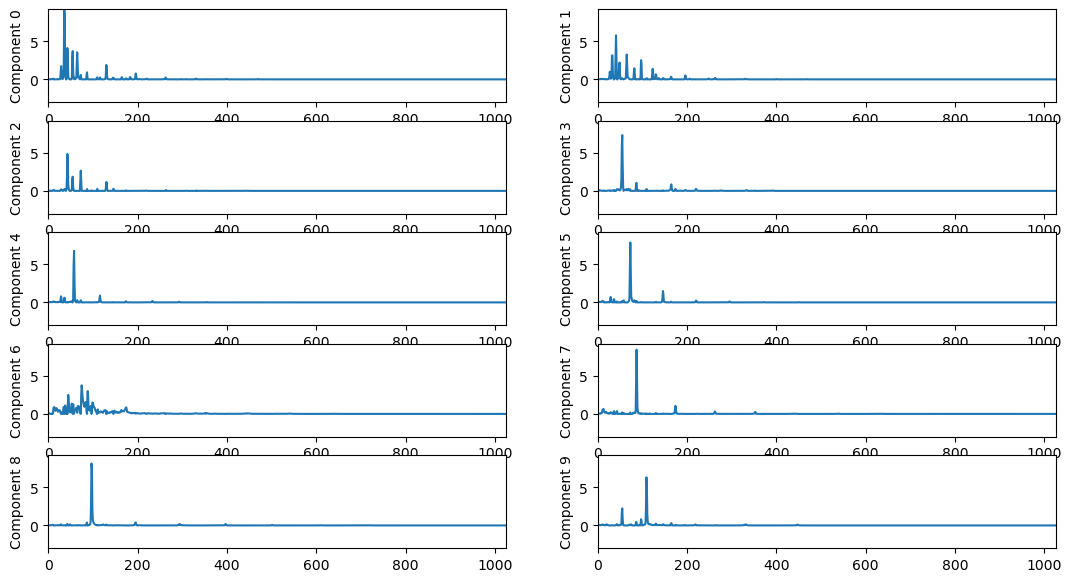

In [31]:
plt.figure(figsize=(13, 7))
for n in range(n_components):
    plt.subplot(5, 2, n+1)
    plt.plot(W[:,n])
    plt.ylim(-3, W.max())
    plt.xlim(0, W.shape[0])
    plt.ylabel('Component %d' % n)
    print(np.argmax(W[:,n]) * 11025/1025) # fs = 22050, only up to fs/2 can be detected properly

In [32]:
print(W.max())

9.201716


Let's display the temporal activations(gains corresponding with basis vectors), $\{h_1, ..., h_R\}$:

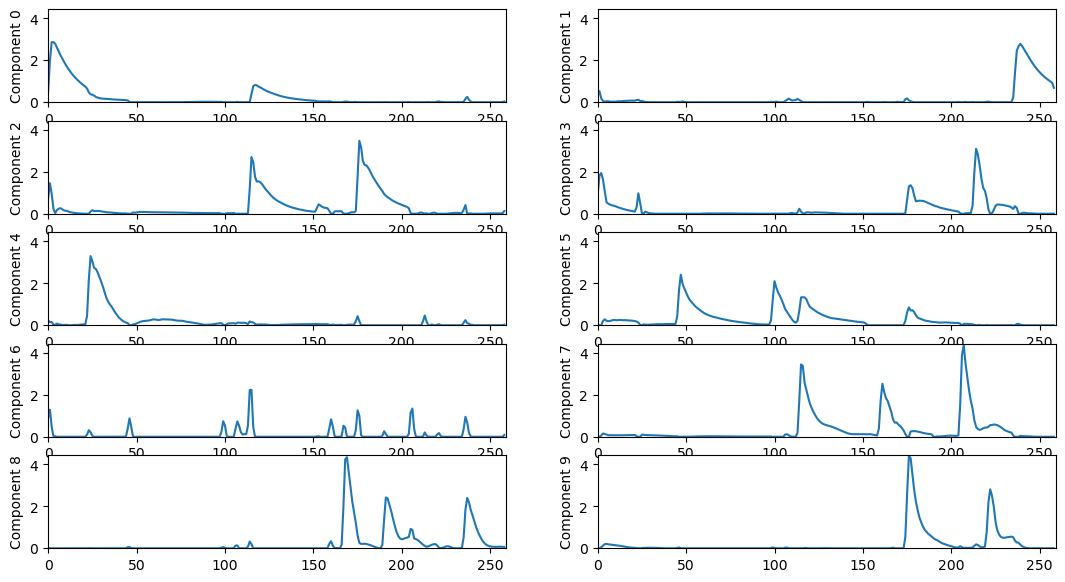

In [33]:
plt.figure(figsize=(13, 7))
for n in range(n_components):
    plt.subplot(5, 2, n+1)
    plt.plot(H[n])
    plt.ylim(0, H.max())
    plt.xlim(0, H.shape[1])
    plt.ylabel('Component %d' % n)

### FILTER and Inverse Short-Time Fourier Transform (ISTFT)
FILTER\
choose a subset of basis vectors Ws and activations Hs to reconstruct source s\
ISTFT\
inputs |X| and phase <X matrices\
outputs time domain signal x

In [34]:
Y = np.dot(W[:0], H[0:])
print(W.shape)
print(W[:,0].shape)
print(H[0].shape)
print(X_phase.shape)

(1025, 10)
(1025,)
(259,)
(1025, 259)


In [40]:
def generate_sine(f0, sr, n_duration):
    n = np.arange(n_duration)
    return 0.2*np.sin(2*np.pi*f0*n/float(sr))

In [42]:
def estimate_pitch_and_generate_sine(x, onset_samples,f0, i, sr):
    n0 = onset_samples[i]
    n1 = onset_samples[i+1]
    return generate_sine(f0, sr, n1-n0)

In [45]:
for n in range(n_components):
    
    # Re-create the STFT of a single NMF component. row of W with the column of H
    Y = np.outer(W[:,n],H[n]) 
    plt.figure(figsize=(14,5))
    #librosa.display.specshow(Y, sr=fs, x_axis='time', y_axis='hz')

    # Transform the STFT into the time domain.
    y = librosa.istft(Y* X_phase)

    f0 = np.argmax(W[:,n]) * 11025/1025 # fs = 22050, only up to fs/2 can be detected properly


    if f0 < 200:
        pass
    else:
        onset_env = librosa.onset.onset_strength(y, sr=fs, hop_length=100)
    
        onset_samples = librosa.onset.onset_detect(y, sr=fs, units='samples',
        hop_length=100, backtrack=False, pre_max=20, post_max=20, 
        pre_avg=100, post_avg=100, delta=0.2, wait=0)
        onset_boundaries = np.concatenate([[0], onset_samples, [len(y)]])
        onset_times = librosa.samples_to_time(onset_boundaries, sr=fs)
        y = np.concatenate([
            estimate_pitch_and_generate_sine(x, onset_boundaries,f0, i, sr=fs)
            for i in range(len(onset_boundaries)-1)
        ])
        print(f0)
        print(onset_times)
        ipd.Audio(y, rate=fs)
    
    print('Component {}:'.format(n))
    #ipd.display( ipd.Audio(y, rate=fs) )

/var/folders/pt/c3pppqgj6rx6ydqlk9zj4s1w0000gn/T/ipykernel_27756/4153286476.py:17: FutureWarning: Pass y=[0.00277691 0.00378301 0.00488387 ... 0.00084268 0.00077927 0.00068165] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  onset_env = librosa.onset.onset_strength(y, sr=fs, hop_length=100)
/var/folders/pt/c3pppqgj6rx6ydqlk9zj4s1w0000gn/T/ipykernel_27756/4153286476.py:19: FutureWarning: Pass y=[0.00277691 0.00378301 0.00488387 ... 0.00084268 0.00077927 0.00068165] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  onset_samples = librosa.onset.onset_detect(y, sr=fs, units='samples',
/var/folders/pt/c3pppqgj6rx6ydqlk9zj4s1w0000gn/T/ipykernel_27756/4153286476.py:17: FutureWarning: Pass y=[0.00769178 0.00783458 0.00791363 ... 0.0166305  0.01701608 0.01691418] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  onset_env = librosa.onset.onset_str

387.219512195122
[0.         0.04988662 2.66666667 3.89115646 5.12018141 5.49659864
 5.9907483 ]
Component 0:
441.0
[0.         1.06575964 2.29931973 2.48526077 3.54195011 4.06349206
 5.4829932  5.9907483 ]
Component 1:
462.5121951219512
[0.         0.04988662 0.55328798 1.1292517  2.65759637 3.55102041
 4.07709751 5.4829932  5.9907483 ]
Component 2:
591.5853658536586
[0.         0.04988662 0.54875283 2.67120181 4.08163265 4.96145125
 5.23356009 5.9907483 ]
Component 3:
623.8536585365854
[0.         0.54875283 2.68027211 4.08163265 4.92970522 5.48752834
 5.9907483 ]
Component 4:


/var/folders/pt/c3pppqgj6rx6ydqlk9zj4s1w0000gn/T/ipykernel_27756/4153286476.py:17: FutureWarning: Pass y=[0.00021123 0.00024301 0.00025598 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  onset_env = librosa.onset.onset_strength(y, sr=fs, hop_length=100)
/var/folders/pt/c3pppqgj6rx6ydqlk9zj4s1w0000gn/T/ipykernel_27756/4153286476.py:19: FutureWarning: Pass y=[0.00021123 0.00024301 0.00025598 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  onset_samples = librosa.onset.onset_detect(y, sr=fs, units='samples',
/var/folders/pt/c3pppqgj6rx6ydqlk9zj4s1w0000gn/T/ipykernel_27756/4153286476.py:17: FutureWarning: Pass y=[-0.00675597 -0.00849078 -0.01065373 ...  0.00176709  0.00164193
  0.00143084] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  onset_env = librosa.onset.on

785.1951219512196
[0.         0.0861678  1.07936508 2.30839002 2.67573696 4.06349206
 5.51927438 5.9907483 ]
Component 5:
806.7073170731708
[0.         0.04988662 0.54421769 1.07482993 2.30839002 2.48526077
 2.66213152 3.55102041 3.71882086 3.89569161 4.07256236 4.42630385
 4.78004535 4.9569161  5.13378685 5.49206349 5.98639456 5.9907483 ]
Component 6:
935.780487804878
[0.         0.6031746  2.67120181 3.7324263  4.13151927 4.7845805
 5.9907483 ]
Component 7:
1043.341463414634
[0.         2.67120181 3.72789116 3.90022676 4.430839   4.79365079
 5.49659864 5.9907483 ]
Component 8:
1172.4146341463415
[0.         0.0952381  4.08163265 4.96598639 5.13378685 5.9907483 ]
Component 9:


<Figure size 1400x500 with 0 Axes>

<Figure size 1400x500 with 0 Axes>

<Figure size 1400x500 with 0 Axes>

<Figure size 1400x500 with 0 Axes>

<Figure size 1400x500 with 0 Axes>

<Figure size 1400x500 with 0 Axes>

<Figure size 1400x500 with 0 Axes>

<Figure size 1400x500 with 0 Axes>

<Figure size 1400x500 with 0 Axes>

<Figure size 1400x500 with 0 Axes>

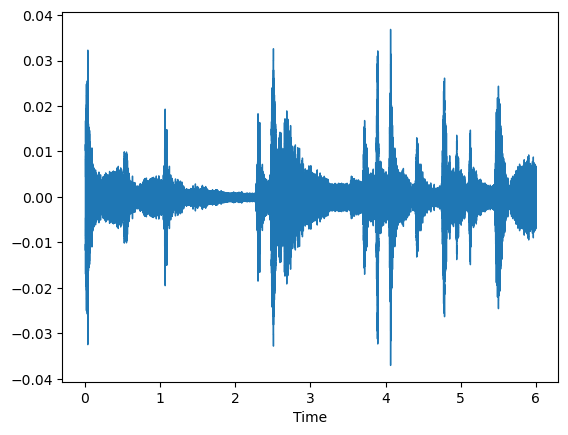

In [36]:
Y = np.dot(W, H)*X_phase

# Transform the STFT into the time domain.
reconstructed_signal = librosa.istft(Y, length=len(x))
ipd.Audio(reconstructed_signal, rate=fs)
#librosa.display.waveshow(reconstructed_signal,sr=fs,)
#error
librosa.display.waveshow(x-reconstructed_signal,sr=fs)

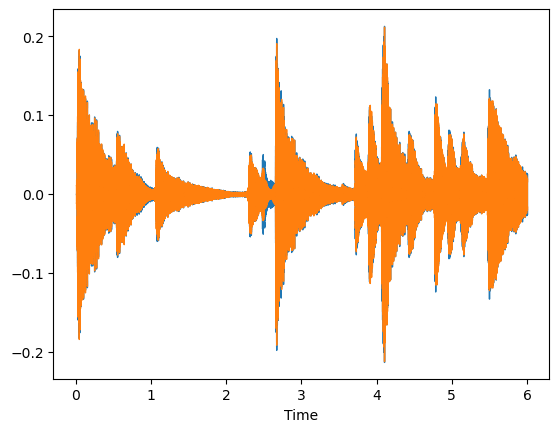

In [37]:
librosa.display.waveshow(x,sr=fs)
librosa.display.waveshow(reconstructed_signal,sr=fs)

In [38]:
residual = x - reconstructed_signal
residual[0] = 1 # hack to prevent automatic gain scaling
#ipd.Audio(residual, rate=fs)
ipd.Audio(x, rate=fs)
